## CPS_ASEC

In [2]:
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

path = '/home/brian/Documents/ASEC/data/'

### Distribution of Personal Income

In [5]:
year = '2022'
yr = int(year) - 1 # CPS ASEC references prior year
write_txt(text_dir / 'asec_year.txt', f'{yr}')
datafile = f'asec{year}_pubuse.dat'
# Retrieve column info from dictionary
variables = ['PRECORD', 'MARSUPWT', 'PEARNVAL', 'ERN_VAL', 'PTOTVAL']
dictfile = f'persfmt{year[2:]}.txt'
dd = open(path + dictfile).read()
p = f'({"|".join(variables)})\s+(\d+)\s+(\d+)\s'
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, dd)}

# Read raw fwf file
df = (pd.read_fwf(path + datafile, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=list(cols.keys()))
        .astype({'MARSUPWT': 'int'})
        .query('PRECORD == 3 and MARSUPWT > 0'))

res = {}
for val in ['PTOTVAL', 'PEARNVAL']:
    res[val] = {}
    for i in range(0,99):
        bins=np.arange(-500, 350000, 500)
        cdf = (df.groupby(pd.cut(df[val], bins))
                 .MARSUPWT.sum().cumsum() / df.MARSUPWT.sum())
        res[val][i] = np.interp(i/100, cdf, bins[1:])

data = pd.DataFrame(res) / 1_000
data['Diff'] = data['PTOTVAL'] - data['PEARNVAL']
data.to_csv(data_dir / 'pearn_dist.csv', index_label='percentile')

In [6]:
data = pd.read_csv(data_dir / 'pearn_dist.csv', index_col='percentile')
data.loc[99] = data.loc[98]
data.index = data.index + 1
threshold = 12880
lab = 100 - data[data['PEARNVAL'] > 0].index[0]
labp = 100 - data[data['PEARNVAL'] > (threshold / 1000)].index[0]
tot = 100 - data[data['PTOTVAL'] > 0].index[0]
color = {'PEARNVAL': 'cyan!50!white', 'Diff': 'violet!50!purple'}
sh150 = (df.loc[df.PTOTVAL > 150000, 'MARSUPWT'].sum() / 
         df['MARSUPWT'].sum()) * 100
text = (f'Over calendar year {yr}, {lab} percent of people have '+
        f'any labor income {c_box(color["PEARNVAL"])}. Only '+
        f'{labp} percent of people have labor income above the '+
        f'single-person poverty threshold of \${threshold:,.0f}.'+
        '\n\nTotal income, includes after-tax labor income plus '+
        f'welfare and capital income, {c_box(color["Diff"])} '+
        f'reaches {tot} percent of people in {yr}. People who '+
        'did not receive any income by the total income measure '+
        'typically live with people who receive income. \n\nIn '+
        f'{yr}, {sh150:.1f} percent of people have total income '+
        'of more than \$150,000. Note that the chart cuts off '+
        'income above \$150,000. ')
write_txt(text_dir / 'pearn.txt', text)
print(text)

Over calendar year 2021, 50 percent of people have any labor income (see\cbox{cyan!50!white}). Only 43 percent of people have labor income above the single-person poverty threshold of \$12,880.

Total income, includes after-tax labor income plus welfare and capital income, (see\cbox{violet!50!purple}) reaches 71 percent of people in 2021. People who did not receive any income by the total income measure typically live with people who receive income. 

In 2021, 4.6 percent of people have total income of more than \$150,000. Note that the chart cuts off income above \$150,000. 


In [31]:
wmed = 100 - (data[data['PEARNVAL'] > 0].index[0] / 2)
wmedt = wmed - 11
text = (f'\draw [black!60] (axis cs:{{{wmed}}},\pgfkeysvalueof{{/pgfplots/ymin}}) -- '+
 f'(axis cs:{{{wmed}}}, \pgfkeysvalueof{{/pgfplots/ymax}});\n'+
 f'\\absnode{{{wmedt}}}{{79}}{{\small \color{{black!75}} worker\\\ \small \color{{black!75}} median}}')
write_txt(text_dir / 'pearn_worker_med.txt', text)

### Real Median Household Income

In [3]:
url = ('https://www2.census.gov/programs-surveys/'+
       'demo/tables/p60/276/tableA2.xlsx')
df = pd.read_excel(url, header=4, index_col=0, skipfooter=34)
# Data covering all races
data = df.loc[:'WHITE ALONE 25'].dropna()
data.index = (pd.to_datetime(data.index.astype('str').str[:4]) + 
               pd.DateOffset(months=6))
res = data[['Estimate', 'Estimate.1']]
res = res.rename({'Estimate': 'Median', 
                  'Estimate.1': 'Mean'}, axis=1)
final = pd.DataFrame()
for col in res.columns:
    i = res[col]
    loc1 = np.where(i.index.get_loc('2017-07-01'))[0][1]
    loc2 = np.where(i.index.get_loc('2013-07-01'))[0][1]
    final = final.join(i.iloc[:loc1].rename(f'{col}_LT'), how='outer')
    final = final.join(i.iloc[loc1: loc2].rename(f'{col}_PR'), how='outer')
    final = final.join(i.iloc[loc2:].rename(f'{col}_PR2'), how='outer')
    
final.loc['1989':].divide(1000).to_csv(data_dir / 'real_hh_inc.csv', 
                                     index_label='date')

# Decile thresholds
url = 'https://www2.census.gov/programs-surveys/demo/tables/p60/276/tableA4.xlsx'
df = pd.read_excel(url, header=5, index_col=0, skipfooter=25)
data = df[['10th percentile limit', '90th percentile limit']]
data.index = (pd.to_datetime(data.index.astype('str').str[:4]) + 
               pd.DateOffset(months=6))
res = data.rename({'10th percentile limit': 'p10', 
                   '90th percentile limit': 'p90'}, axis=1)
final = pd.DataFrame()
for col in res.columns:
    i = res[col]
    loc1 = np.where(i.index.get_loc('2017-07-01'))[0][1]
    loc2 = np.where(i.index.get_loc('2013-07-01'))[0][1]
    final = final.join(i.iloc[:loc1].rename(f'{col}_LT'), how='outer')
    final = final.join(i.iloc[loc1: loc2].rename(f'{col}_PR'), how='outer')
    final = final.join(i.iloc[loc2:].rename(f'{col}_PR2'), how='outer')
    
final.loc['1989':].divide(1000).to_csv(data_dir / 'real_hh_inc_dec.csv', 
                                     index_label='date')

In [89]:
df = pd.read_csv(data_dir / 'real_hh_inc.csv', parse_dates=True,
                 index_col='date') * 1000
clmean = c_line('cyan')
ltdt = dtxt(df.index[-1])['year']
prdt = dtxt(df.index[-2])['year']
prdt2 = dtxt(df.index[-3])['year']
vallt = df['Mean_LT'].iloc[-1]
valpr = df['Mean_LT'].iloc[-2]
valpr2 = df['Mean_LT'].iloc[-3]
val00 = df.loc['2000', 'Mean_PR2'].iloc[0]

text = (f'The mean or average household income is \${vallt:,.0f} in '+
        f'{ltdt} {clmean}, compared to \${valpr:,.0f} in {prdt}, and '+
        f'\${valpr2:,.0f} in {prdt2}. In 2000, real mean household '+
        f'income was \${val00:,.0f}. ')
write_txt(text_dir / 'hh_inc1.txt', text)
print(text, '\n')

clmed = c_line('violet')
valmedlt = df['Median_LT'].iloc[-1]
valmedpr = df['Median_LT'].iloc[-2]
valmedpr2 = df['Median_LT'].iloc[-3]
valmed00 = df.loc['2000', 'Median_PR2'].iloc[0]
medch = ((df['Median_LT'].iloc[-1] / 
          df.loc['2000', 'Median_PR2'].iloc[0]) - 1) * 100
medincdec = value_text(medch, adj='total')

text = (f'Real median household income {clmed}, the price-adjusted '+
        f'midpoint among household incomes, is \${valmedlt:,.0f} in '+
        f'{ltdt}, \${valmedpr:,.0f} in {prdt}, and \${valmedpr2:,.0f} in '+
        f'{prdt2}. For comparison, real median household income was '+
        f'\${valmed00:,.0f} in 2000. Since 2000, real median income '+
        f'{medincdec}.')
write_txt(text_dir / 'hh_inc2.txt', text)
print(text, '\n')

df = pd.read_csv(data_dir / 'real_hh_inc_dec.csv', parse_dates=True,
                 index_col='date') * 1000
cl90 = c_line('teal')
cl10 = c_line('orange!80!yellow')
val90lt = df['p90_LT'].iloc[-1]
val90pr = df['p90_LT'].iloc[-2]
val90pr2 = df['p90_LT'].iloc[-3]
val9000 = df.loc['2000', 'p90_PR2'].iloc[0]
val10lt = df['p10_LT'].iloc[-1]
val10pr = df['p10_LT'].iloc[-2]
val10pr2 = df['p10_LT'].iloc[-3]
val1000 = df.loc['2000', 'p10_PR2'].iloc[0]

text = ('The price-adjusted income limit for the 90th percentile '+
        f'is \${val90lt:,.0f} in {ltdt} {cl90}, \${val90pr:,.0f} in {prdt}, '+
        f'\${val90pr2:,.0f} in {prdt2}, and \${val9000:,.0f} in 2000. Ten '+
        'percent of households make more than this level. \n\n'+
        'On the opposite end of the income distribution, the 10th '+
        f'percentile income limit is \${val10lt:,.0f} in {ltdt} {cl10}, '+
        f'\${val10pr:,.0f} in {prdt}, \${val10pr2:,.0f} in {prdt2}, and '+
        f'\${val1000:,.0f} in 2000. Ten percent of households make '+
        'less than this level. ')
write_txt(text_dir / 'hh_inc3.txt', text)
print(text)

The mean or average household income is \$102,316 in 2021 (see {\color{cyan}\textbf{---}}), compared to \$102,020 in 2020, and \$103,949 in 2019. In 2000, real mean household income was \$90,142.  

Real median household income (see {\color{violet}\textbf{---}}), the price-adjusted midpoint among household incomes, is \$70,784 in 2021, \$71,186 in 2020, and \$72,808 in 2019. For comparison, real median household income was \$66,248 in 2000. Since 2000, real median income increased by a total of 6.8 percent. 

The price-adjusted income limit for the 90th percentile is \$211,956 in 2021 (see {\color{teal}\textbf{---}}), \$211,438 in 2020, \$213,171 in 2019, and \$176,702 in 2000. Ten percent of households make more than this level. 

On the opposite end of the income distribution, the 10th percentile income limit is \$15,660 in 2021 (see {\color{orange!80!yellow}\textbf{---}}), \$16,386 in 2020, \$16,984 in 2019, and \$16,695 in 2000. Ten percent of households make less than this level. 

In [76]:
# Median Household income by race/ethnicity
url = ('https://www2.census.gov/programs-surveys/'+
       'demo/tables/p60/276/tableA2.xlsx')
df = pd.read_excel(url, header=4, index_col=0, skipfooter=34)
grps = [('Black', 'BLACK ALONE 27', 'ASIAN ALONE OR IN COMBINATION', 
         'BLACK 26'),
        ('Asian', 'ASIAN ALONE 28', 'AMERICAN INDIAN AND ALASKA NATIVE ALONE OR IN COMBINATION', 
         'ASIAN AND PACIFIC ISLANDER 26'),
        ('White', 'WHITE ALONE, NOT HISPANIC 25', 
         'BLACK ALONE OR IN COMBINATION', 'WHITE, NOT HISPANIC 26'),
        ('Hispanic', 'HISPANIC (ANY RACE) 30', '', '')]
data = (df['Estimate'].reset_index().fillna(method='ffill', axis=1)
        .set_index('index'))
res = pd.DataFrame()
for name, start, end, drop in grps:
    if end == '':
        s = (data.loc[start: ].iloc[1:-1]).Estimate
    else:
        s = (data.loc[start: end].iloc[1:-1].drop(drop)).Estimate
    s.index = (pd.to_datetime(s.index.astype('str').str[:4]) + 
               pd.DateOffset(months=6))
    loc1 = np.where(s.index.get_loc('2017-07-01'))[0][1]
    loc2 = np.where(s.index.get_loc('2013-07-01'))[0][1]
    res = res.join(s.iloc[:loc1].rename(f'{name}_LT'), how='outer')
    res = res.join(s.iloc[loc1: loc2].rename(f'{name}_PR'), how='outer')
    res = res.join(s.iloc[loc2:].rename(f'{name}_PR2'), how='outer')
    
res.loc['1989':].divide(1000).to_csv(data_dir / 'real_med_hh_inc.csv', 
                                     index_label='date')

cols = [('Wh', 'green!80!black'), ('Bl', 'blue!80!black'), 
        ('Hi', 'red!90!black'), ('As', 'orange')]
cl = {name: c_line(color) for name, color in cols}
ltdt = res.index[-1].year
write_txt(text_dir / 'rmhi_ltdt.txt', f'{ltdt}')
prdt = res.index[-2].year
ltval = res.iloc[-1].dropna().apply(lambda x: f'\${x:,.0f}')
prval = res.iloc[-2].dropna().apply(lambda x: f'\${x:,.0f}')
text = (f'Black median household income was {ltval.Black_LT} in '+
        f'{ltdt}, compared to an inflation-adjusted equivalent '+
        f'of {prval.Black_LT} in {prdt} {cl["Bl"]}. Non-Hispanic '+
        f'white median household income was {ltval.White_LT} in '+
        f'{ltdt} and {prval.White_LT} in {prdt} {cl["Wh"]}. '+
        f'Hispanic (any race) median household income was '+
        f'{ltval.Hispanic_LT} in {ltdt} and {prval.Hispanic_LT} '+
        f'in {prdt} {cl["Hi"]}. Asian median household income was '+
        f'{ltval.Asian_LT} in {ltdt} and {prval.Asian_LT} in '+
        f'{prdt} {cl["As"]}. ')
write_txt(text_dir / 'real_med_hh_inc.txt', text)
print(text)

Black median household income was \$48,297 in 2021, compared to an inflation-adjusted equivalent of \$48,175 in 2020 (see {\color{blue!80!black}\textbf{---}}). Non-Hispanic white median household income was \$77,999 in 2021 and \$78,912 in 2020 (see {\color{green!80!black}\textbf{---}}). Hispanic (any race) median household income was \$57,981 in 2021 and \$58,015 in 2020 (see {\color{red!90!black}\textbf{---}}). Asian median household income was \$101,418 in 2021 and \$99,622 in 2020 (see {\color{orange}\textbf{---}}). 


### Full-time, full-year workers

In [7]:
ltyear = 2022
pry, lty = [str(ltyear-1), str(ltyear)]
res = {}
for year in [pry, lty]:
    res[year] = {}
    varlist = ['WEWKRS', 'MARSUPWT', 'PRECORD']
    dictfile = f'{path}/persfmt{year[2:]}.txt'
    dd = open(dictfile).read()
    p = f'({"|".join(varlist)})\s+(\d+)\s+(\d+)\s'
    cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
            for name, length, start in re.findall(p, dd)}

    datafile = f'{path}/asec{year}_pubuse.dat'
    df = (pd.read_fwf(datafile, 
                      colspecs=list(cols.values()), 
                      header=None, 
                      names=list(cols.keys()))
            .query('PRECORD == 3'))
    
    data = df.groupby('WEWKRS').MARSUPWT.sum() / 100_000_000
    res[year]['tot'] = data[1]
    res[year]['sh'] = data[1] / data.sum() * 100

text = (f'{res[lty]["tot"]:.1f} million fully-employed people in '+
        f'{ltyear - 1}, equivalent to {res[lty]["sh"]:.1f} percent '+
        f'of the US population, compared to {res[pry]["tot"]:.1f} '+
        f'million ({res[pry]["sh"]:.1f} percent) in {ltyear - 2}. ')
write_txt(text_dir / 'asec_ftfy_tot.txt', text)
print(text)

117.4 million fully-employed people in 2021, equivalent to 35.7 percent of the US population, compared to 105.5 million (32.3 percent) in 2020. 


### Poverty Rates (SPM and OPM)

In [12]:
# Historical SPM
#url = ('https://www.povertycenter.columbia.edu/s/'+
#       'Anchored-and-Historical-Poverty-Rates-1967-to-2020.xlsx')

data = [(1989, 14.3), (1990, 14.8), (1991, 15.2), (1992, 15.8),
        (1993, 16.8), (1994, 15.7), (1995, 14.2), (1996, 14.1), 
        (1997, 13.6), (1998, 13.0), (1999, 12.4), (2000, 12.4), 
        (2001, 13.2), (2002, 13.6), (2003, 13.8), (2004, 13.7), 
        (2005, 13.7), (2006, 13.8), (2007, 14.4), (2008, 14.8)]
idx, values = zip(*data)

spmh = pd.Series(values, idx).rename('PR4')
spmh.index = (pd.to_datetime(spmh.index.astype('str')) + 
              pd.DateOffset(months=6))

In [21]:
url = ('https://www2.census.gov/programs-surveys/demo/tables/'+
       'p60/277/tableA4_hist_pov_by_family_type.xlsx')
df = pd.read_excel(url, header=6, index_col=0, skipfooter=34)
df = (df['Percent'].reset_index().fillna(method='ffill', axis=1)
        .set_index('index'))
s = df.loc['ALL RACES': 'WHITE ALONE23', 'Percent'].iloc[1:-1]
s.index = (pd.to_datetime(s.index.astype('str').str[:4]) + 
               pd.DateOffset(months=6))
loc1 = np.where(s.index == '2013-07-01')[0][1]
loc2 = np.where(s.index == '2013-07-01')[0][1]
res = pd.DataFrame()
res = res.join(s.iloc[:loc1].rename(f'OPM_LT'), how='outer')
res = res.join(s.iloc[loc1: loc2].rename(f'OPM_PR'), how='outer')
res = res.join(s.iloc[loc2:].rename(f'OPM_PR2'), how='outer')
    
res.loc['1989':].to_csv(data_dir / 'poverty_opm_line.csv', 
                                     index_label='date')
opmcol = 'green!80!blue'
node = end_node(res.OPM_LT, opmcol, date='y', percent=True, 
                full_year=True, offset=0.16)
write_txt(text_dir / 'poverty_opm_node.txt', node)

#SPM manual
spm = {'PR4': {'2009': 15.1, '2010': 16.0, '2011': 16.1, 
               '2012': 16.0, '2013': 15.5},
       'PR3': {'2013': 15.8, '2014': 15.3, '2015': 14.3},
       'PR2': {'2015': 14.5, '2016': 14.0, '2017': 13.9},
       'PR': {'2017': 13.0, '2018': 12.8, '2019': 11.7},
       'LT': {'2019': 11.8, '2020': 9.2, '2021': 7.8}}

sp = pd.DataFrame(spm)
sp.index = (pd.to_datetime(sp.index.astype('str').str[:4]) + 
               pd.DateOffset(months=6))
sp = pd.concat([spmh.to_frame(), sp])  
sp.to_csv(data_dir / 'poverty_spm_line.csv', index_label='date')
spmcol = 'blue!80!green' 
node = end_node(sp.LT, spmcol, percent=True)
write_txt(text_dir / 'poverty_spm_node.txt', node)

maxval = res.loc['1989':].max().max()
minval = res.loc['1989':].min().min()
avgval = res.loc['1989':].mean().mean()

val21 = sp.loc['2021-07-01', 'LT']

text = (f'Since 1989, the official poverty measure {c_line(opmcol)} '+
        f'shows between {minval} percent and {maxval} percent '+
        f'of people in poverty, with an average poverty rate '+
        f'of {avgval:.1f} percent during the period. Poverty '+
        'rates were above average after the recession of 1991 and after '+
        'the great recession, and below average around 2000.\n\nIn 2019, '+
        'both the official US poverty measure and the more-comprehensive '+
        f'supplemental measure {c_line(spmcol)} reached a new low. In '
        '2021, the supplemental poverty measure fell further, to a new '+
        f'low of {val21} percent, while the official measure increased. '+
        'The official poverty rate does not include stimulus checks, '+
        'housing assistance, or tax credits, while the supplemental '+
        'rate does.')
write_txt(text_dir / 'poverty_rate_time.txt', text)
print(text)

Since 1989, the official poverty measure (see {\color{green!80!blue}\textbf{---}}) shows between 10.5 percent and 15.1 percent of people in poverty, with an average poverty rate of 13.0 percent during the period. Poverty rates were above average after the recession of 1991 and after the great recession, and below average around 2000.

In 2019, both the official US poverty measure and the more-comprehensive supplemental measure (see {\color{blue!80!green}\textbf{---}}) reached a new low. In 2021, the supplemental poverty measure fell further, to a new low of 7.8 percent, while the official measure increased. The official poverty rate does not include stimulus checks, housing assistance, or tax credits, while the supplemental rate does.


### Who are the poor?

Attempt to replicate excellent chart by Matt Bruenig

----

Source: CPS ASEC

In [4]:
year = 2021
write_txt(text_dir / 'poverty_ltyear.txt', f'{year}')

# Extract person records for selected variables
variables = ['H_SEQ', 'PPPOS', 
             'PRECORD', 'A_AGE', 'MARSUPWT', 'PERLIS', 
             'SPM_Resources', 'SPM_PovThreshold', 'WKSWORK',
             'PRDISFLG', 'RSNNOTW', 'PYRSN', 'LKWEEKS',
             'SPM_Weight', 'SPM_ID', 'SPM_CapWkCCXpns',
             'SPM_Totval', 'SPM_MedXpns', 'SPM_ChildSupPd',
             'SPM_Poor', 'SPM_NumPer', 'SPM_EIP']

benefits = ['SS_VAL', 'SSI_VAL', 'UC_VAL', 'VET_VAL', 
            'WC_VAL', 'PAW_VAL']

dictfile = f'{path}/persfmt22.txt'
dd = open(dictfile).read()
p = f'({"|".join(variables + benefits)})\s+(\d+)\s+(\d+)\s'
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, dd)}

datafile = f'{path}/asec2022_pubuse.dat'
df = (pd.read_fwf(datafile, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=list(cols.keys()))
        .query('PRECORD == 3'))

In [5]:
# Categorize population
df['Category'] = (np.where(df.A_AGE < 18, 'Children', 
                  np.where(df.A_AGE > 64, 'Elderly', 
                  np.where(((df.PRDISFLG == 1) | (df.PYRSN == 1) | (df.RSNNOTW == 1)), 'Disabled', 
                  np.where(((df.PYRSN == 3) | (df.RSNNOTW == 4)), 'Students', 
                  np.where(((df.PYRSN == 2) | (df.RSNNOTW == 3)), 'Carers',
                  np.where(((df.PYRSN == 5) | (df.RSNNOTW == 5) | (df.LKWEEKS > 0)), 'Unemployed',         
                  np.where(((df.PYRSN == 4) | (df.RSNNOTW == 2)), 'Early Retired',  
                  np.where(df.WKSWORK > 49, 'Fully Employed', 'All Other')))))))))

df['AGE_GRP'] = pd.cut(df.A_AGE, range(0, 79, 3))

df['SPM'] = np.where(df['SPM_Resources'] < df['SPM_PovThreshold'], 1, 0)
df['OPM'] = np.where(df['PERLIS'] == 1, 1, 0)
df['MARKET_INCOME'] = (df['SPM_Totval'] - 
                       df[['SPM_CapWkCCXpns','SPM_MedXpns', 'SPM_ChildSupPd']].sum(axis=1) - 
                       df[benefits].sum(axis=1).groupby(df['SPM_ID']).transform('sum'))

df['SPM_MI'] = np.where(df['MARKET_INCOME'] < df['SPM_PovThreshold'], 1, 0)
df['MI_GAP'] = ((df['SPM_PovThreshold'] - df['MARKET_INCOME']) / 
                df['SPM_NumPer']) * df['SPM_Weight'] / 100
df['SPM_GAP'] = ((df['SPM_PovThreshold'] - df['SPM_Resources']) / 
                 df['SPM_NumPer']) * df['SPM_Weight'] / 100

In [6]:
# Only below poverty line
data = df.query('SPM == 1')
data2 = df.query('OPM == 1')
data3 = df.query('SPM_MI == 1')

results = pd.DataFrame()

# Group share of total
results['SPM'] = (data.groupby('Category').SPM_Weight.sum() / 
                  data.SPM_Weight.sum() * 100).sort_values(ascending=False)

results['OPM'] = (data2.groupby('Category').MARSUPWT.sum() / 
                  data2.MARSUPWT.sum() * 100).sort_values(ascending=False)


results['SPM_MI'] = (data3.groupby('Category').SPM_Weight.sum() / 
                  data3.SPM_Weight.sum() * 100).sort_values(ascending=False)

results.to_csv(data_dir / 'poor.csv', index_label='name')
print(results)

                      SPM        OPM     SPM_MI
Category                                       
Elderly         24.247951  15.300705  35.025641
Disabled        15.935322  16.536749  13.727863
Children        14.710380  29.388754  20.320544
Fully Employed  11.164948   7.779601   9.246116
Unemployed       7.972807   6.949603   5.171902
Carers           7.340135   8.532235   4.969725
All Other        7.158846   6.867585   4.630831
Students         6.756832   5.516754   3.282633
Early Retired    4.712779   3.128014   3.624746


In [7]:
results2 = pd.DataFrame()

# Poverty rate of each group
results2['SPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM'], weights=x['SPM_Weight']))
                     * 100).loc[results.index]
results2['OPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['OPM'], weights=x['MARSUPWT']))
                     * 100).loc[results.index]

results2['SPM_MI'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM_MI'], weights=x['SPM_Weight']))
                     * 100).loc[results.index]

results2.to_csv(data_dir / 'poor2.csv', index_label='name')
print(results2)

                      SPM        OPM     SPM_MI
Category                                       
Elderly         10.638173  10.329290  47.044890
Disabled        18.855386  28.329685  49.729246
Children         5.193788  15.175046  21.964941
Fully Employed   2.385637   2.478399   6.048412
Unemployed      15.761889  19.833284  31.302692
Carers          15.500523  26.957612  32.129871
All Other       10.583062  14.809151  20.958567
Students        21.877452  24.792004  32.539458
Early Retired   18.264164  18.229746  43.006549


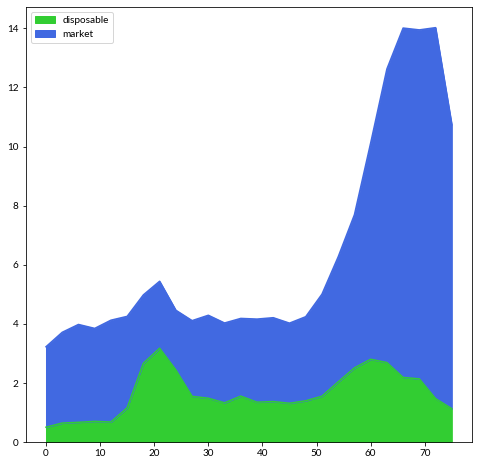

In [8]:
results3 = pd.DataFrame()
results3['disposable'] = (data.groupby('AGE_GRP')['SPM_GAP'].sum() / 3e9)
results3['market'] = (data3.groupby('AGE_GRP')['MI_GAP'].sum() / 3e9) - results3['disposable']

results3.index = [i.left for i in results3.index]
results3.to_csv(data_dir / 'poor_age_latest.csv', index_label='age')
results3.iloc[::-1].plot(kind='area', stacked=True, figsize=(8,8), color=['limegreen', 'royalblue']);

In [10]:
mi_tot = df.query('SPM_MI == 1').MARSUPWT.sum() / 1_000_000 / 100
mi_rt = np.average(df['SPM_MI'], weights=df['MARSUPWT']) * 100
spm_tot = df.query('SPM == 1').MARSUPWT.sum() / 1_000_000 / 100
spm_rt = np.average(df['SPM'], weights=df['MARSUPWT']) * 100
ch_val = mi_tot - spm_tot

text = (f'In {year}, income from labor and capital ownership, called '+
        '\\textit{market income}, was below the Census Bureau threshold '+
        f'for poverty for {mi_tot:.1f} million people in the US, '+
        f'equivalent to {mi_rt:.1f} percent of the population. '+
        'An adjusted measure called \\textit{disposable income} includes market '+
        'income plus income from government programs and tax credits, '
        'and subtracts taxes paid. '+
        '\href{https://www.census.gov/library/publications/2019/demo/p60-268.html}{According} '+
        'to the Census Bureau Supplemental Poverty Measure (SPM), '+
        f'\\textbf{{{spm_tot:.1f} million people are in poverty}} based '+
        f'on their disposable income, equivalent to {spm_rt:.1f} percent of the '+
        'population. Government programs and tax credits moved the income of '+
        f'{ch_val:.1f} million people above the poverty threshold.')

print(text)

write_txt(text_dir / 'poverty_main.txt', text)

groups = ['Children', 'Elderly', 'Disabled', 'Carers', 'Students']
group_share = results.loc[groups, 'SPM'].sum()

text = f'These groups represent {group_share:.1f} percent of those in poverty in {year}.'

write_txt(text_dir / 'poverty_groups.txt', text)

In 2021, income from labor and capital ownership, called \textit{market income}, was below the Census Bureau threshold for poverty for 78.2 million people in the US, equivalent to 23.8 percent of the population. An adjusted measure called \textit{disposable income} includes market income plus income from government programs and tax credits, and subtracts taxes paid. \href{https://www.census.gov/library/publications/2019/demo/p60-268.html}{According} to the Census Bureau Supplemental Poverty Measure (SPM), \textbf{25.5 million people are in poverty} based on their disposable income, equivalent to 7.8 percent of the population. Government programs and tax credits moved the income of 52.7 million people above the poverty threshold.


### 2014 Data for comparison

In [18]:
spm = pd.read_stata(f'{path}/spmresearch2014.dta')

In [19]:
dictfile = f'{path}/asec2015early_pubuse.dd.txt'
dd = open(dictfile, encoding='iso-8859-1').read()
p = re.compile(f'D ({"|".join(variables + benefits)})\s+(\d+)\s+(\d+)\s+')
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, dd)}

datafile = f'{path}/asec2015_pubuse.dat'
df = (pd.read_fwf(datafile, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=list(cols.keys()))
        .query('PRECORD == 3').astype('int'))

In [20]:
df = pd.merge(spm, df, left_on=['h_seq', 'pppos'], right_on=['H_SEQ', 'PPPOS'])

# Categorize population
df['Category'] = (np.where(df.A_AGE < 18, 'Children', 
                  np.where(df.A_AGE > 64, 'Elderly', 
                  np.where(((df.PRDISFLG == 1) | (df.PYRSN == 1) | (df.RSNNOTW == 1)), 'Disabled', 
                  np.where(((df.PYRSN == 3) | (df.RSNNOTW == 4)), 'Students', 
                  np.where(((df.PYRSN == 2) | (df.RSNNOTW == 3)), 'Carers',
                  np.where(((df.PYRSN == 5) | (df.RSNNOTW == 5) | (df.LKWEEKS > 0)), 'Unemployed',         
                  np.where(((df.PYRSN == 4) | (df.RSNNOTW == 2)), 'Early Retired',  
                  np.where(df.WKSWORK > 49, 'Fully Employed', 'All Other')))))))))

df['AGE_GRP'] = pd.cut(df.A_AGE, range(0, 79, 3))

df['SPM'] = np.where(df['spmu_poor'] == 1, 1, 0)
df['OPM'] = np.where(df['PERLIS'] == 1, 1, 0)
df['MARKET_INCOME'] = (df['spmu_totval'] - 
                       df[['spmu_capwknchcarexpns','spmu_medoopnmcareb', 'spmu_childsuppd']].sum(axis=1) - 
                       df[benefits].sum(axis=1).groupby(df['spmu_id']).transform('sum'))

df['SPM_MI'] = np.where(df['MARKET_INCOME'] < df['spmu_povthreshold'], 1, 0)

df['MI_GAP'] = ((df['spmu_povthreshold'] - df['MARKET_INCOME']) / df['spmu_numper']) * df['spmu_weight'] / 100
df['SPM_GAP'] = ((df['spmu_povthreshold'] - df['spmu_resources']) / df['spmu_numper']) * df['spmu_weight'] / 100

In [21]:
# Only below poverty line
data = df.query('SPM == 1')
data2 = df.query('OPM == 1')
data3 = df.query('SPM_MI == 1')

results = pd.DataFrame()

# Group share of total
results['SPM'] = (data.groupby('Category').spmu_weight.sum() / 
                  data.spmu_weight.sum() * 100).sort_values(ascending=False)

results['OPM'] = (data2.groupby('Category').MARSUPWT.sum() / 
                  data2.MARSUPWT.sum() * 100).sort_values(ascending=False)

results['SPM_MI'] = (data3.groupby('Category').spmu_weight.sum() / 
                  data3.spmu_weight.sum() * 100).sort_values(ascending=False)
print(results)

                      SPM        OPM     SPM_MI
Category                                       
Children        25.924970  33.823404  24.266931
Fully Employed  16.304491  10.080446  11.606246
Elderly         13.769305   9.761345  27.532471
Disabled        12.904645  14.852713  13.947804
Carers           8.679352   9.720166   6.423687
Unemployed       8.291804   8.243360   6.044157
Students         8.158302   7.904065   5.153203
Early Retired    3.382392   3.065769   3.394216
All Other        2.584739   2.548731   1.631286


In [22]:
results2 = pd.DataFrame()

# Poverty rate of each group
results2['SPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM'], weights=x['spmu_weight']))
                     * 100).loc[results.index]
results2['OPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['OPM'], weights=x['MARSUPWT']))
                     * 100).loc[results.index]

results2['SPM_MI'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM_MI'], weights=x['spmu_weight']))
                     * 100).loc[results.index]
print(results2)

                      SPM        OPM     SPM_MI
Category                                       
Children        16.987500  21.515458  28.250489
Fully Employed   6.994778   4.137612   8.846232
Elderly         14.425015   9.979379  51.244745
Disabled        28.174830  30.672190  54.102955
Carers          26.036791  28.098275  34.236115
Unemployed      27.551753  25.401457  35.680903
Students        28.323841  24.777499  31.785531
Early Retired   23.477962  20.596569  41.857744
All Other       23.874094  22.185618  26.769496


#### Price adjustment
https://www.bls.gov/cpi/research-series/r-cpi-u-rs-allitems.pdf

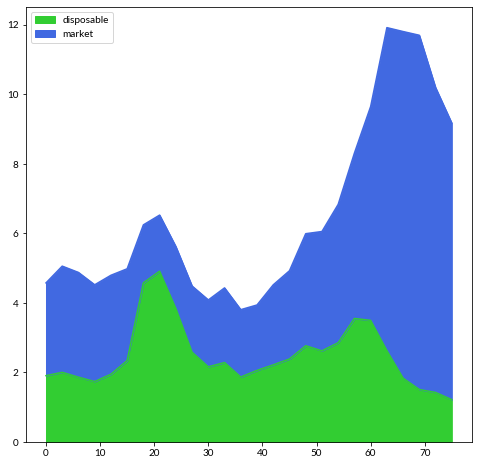

In [24]:
results3 = pd.DataFrame()
results3['disposable'] = (data.groupby('AGE_GRP')['SPM_GAP'].sum() / 3e9)# - results3['ca_gap']
results3['market'] = (data3.groupby('AGE_GRP')['MI_GAP'].sum() / 3e9) - results3['disposable']# - results3['ca_gap']
cpi = pd.read_csv(data_dir / 'cpi_u_rs.csv', index_col='date', parse_dates=True)
results3 = (results3 * cpi.loc['2021-07-01', 'value'] / cpi.loc['2014-07-01', 'value']) # CPI-U-RS
results3.index = [i.left for i in results3.index]
results3.to_csv(data_dir / 'poor_age_prev.csv', index_label='age')
results3.iloc[::-1].plot(kind='area', stacked=True, figsize=(8,8), color=['limegreen', 'royalblue']);